In [12]:
import torch
import torch.nn as nn
from pyhessian import hessian
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
import scipy as sp

epochs = 5
n_tasks = 1
L = 0
gamma0 = 1
widths = [1024]
device = 'mps'
gen = torch.Generator(device=device)
gen.manual_seed(123)
batch = 500

class MLP(nn.Module):
            def __init__(self, w, L, param, gam):
                super(MLP, self).__init__()
                self.w = w
                if param =='ntk':
                    self.gamma = gam
                    self.in_scale = 784**0.5
                    self.out_scale = self.w**0.5*self.gamma*8
                elif param == 'mup': 
                     self.gamma = gam*self.w**0.5
                     self.in_scale = 784**0.5
                     self.out_scale = self.w**0.5*self.gamma
                elif param == 'sp':
                     self.gamma = 1
                     self.in_scale = 1
                     self.out_scale = 1

                self.fc1 = nn.Linear(784, self.w, bias=False)
                self.fc2 = nn.Linear(self.w, 10, bias=False)
                self.relu = nn.ReLU()
                self.L = L

            def forward(self, x):
                h1 = self.fc1(x)/self.in_scale
                h1act = self.relu(h1)
                h2 = self.fc2(h1act)/self.out_scale

                return h2
            
@torch.no_grad()
def init_weights(m):
    if type(m) == nn.Linear:
        m.weight.normal_()

def permut_row(x, perm):
            return x[perm]

        # ---------------------- START DATA -------------------------
data = pd.read_csv('~/data/MNIST/mnist_train.csv')
test = pd.read_csv('~/data/MNIST/mnist_test.csv')
#data = data[data['label'].isin([0, 1])]
#test = test[test['label'].isin([0, 1])]
X = torch.tensor(data.drop('label', axis = 1).to_numpy(), device=device)/255
X_test = torch.tensor(test.drop('label', axis = 1).to_numpy(), device=device)/255
#X = X[:100]

Y_temp = torch.tensor(data['label'].to_numpy(), device=device)
Y = torch.eye(10, device=device)[Y_temp]
#Y = Y[:100]

Y_temp = torch.tensor(test['label'].to_numpy(), device=device)
Y_test = torch.eye(10, device=device)[Y_temp]

tasks = [X]
tasks_test = [X_test]

perc = 0.1
lim = int((784-int(X.shape[1]*perc))/2)

for _ in range(n_tasks):
        par_perm = np.append(np.append(np.arange(0,lim,1),np.random.permutation(int(X.shape[1]*perc))+lim), np.arange(int(X.shape[1]*perc)+lim,784,1))
        #perm = np.random.permutation(X.shape[1])
        tasks.append( torch.tensor(np.apply_along_axis(permut_row, axis = 1, arr=X.cpu(), perm=par_perm)).to(device) )
        tasks_test.append(torch.tensor(np.apply_along_axis(permut_row, axis = 1, arr=X_test.cpu(), perm=par_perm)).to(device))


def top_eigen(model, loss, X, Y, prt=False):

            hess_comp = hessian(model, loss, (X,Y) )
            top_eigenvalues, top_eigenvector = hess_comp.eigenvalues()
                
            return top_eigenvalues[-1] , top_eigenvector

def overlap(model, inputs, targets):
    
    gradients = torch.cat([param.grad.view(-1) for param in model.parameters()])
    params = torch.cat([param.data.view(-1) for param in model.parameters()])

    norm = torch.norm(params)

    def loss_fn(params):
        idx = 0
        layers = []
        for param in model.parameters():
            param_numel = param.numel()
            layers.append(params[idx:idx + param_numel].view_as(param))
            idx += param_numel
        relu = nn.ReLU()
        outputs = relu(inputs@layers[0].T) @ layers[1].T
        return MSE(outputs, targets)

    hvp = torch.autograd.functional.hvp(loss_fn, params, gradients)[1]
    return (torch.dot(hvp,gradients)/(torch.norm(hvp) * torch.norm(gradients))).item(), norm.item()


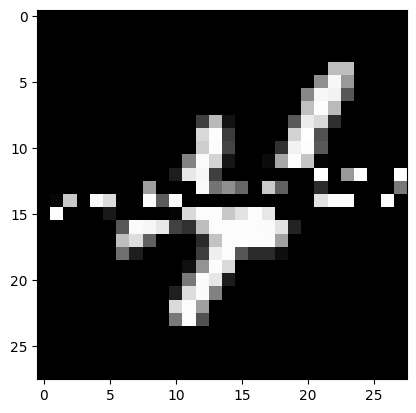

In [13]:
plt.imshow(tasks[1][9].view(28,28).cpu(), cmap='gray')

In [14]:
save_out = False

for regime in ['ntk','mup']:
    for N in widths:

        loss_hist = []
        lam = []
        acc = []
        all = []
        norm = []
        res1 = []
        res2 = []
        run_acc = []
        
        mlp = MLP(N,L,regime, gamma0)
        lrs = {'sp':1,'ntk':1,'mup': mlp.gamma**2}
        lr = lrs.get(regime)

        if regime == 'ntk' or regime == 'mup':
            mlp = mlp.apply(init_weights)
            
        summary(mlp, (1,784))
        mlp = mlp.to(device)
        
        optimizer = torch.optim.SGD(mlp.parameters(), lr= lr )
        eos = 2/lr
     
        MSE = nn.MSELoss()

        for t,Xt in enumerate(tasks):        
                for epoch in range(epochs):

                        running_loss = 0.0
                        for i in range(len(Xt)//batch):

                            # Batch of training 
                            ix = torch.randint(0, len(X), (batch,), generator=gen, device=device)

                            ixc = torch.randint(0, len(X), (1024,), generator=gen, device=device)

                            lt = []
                            for s in range(t+1):
                                sharp, eigen = top_eigen(mlp, MSE, tasks[s][ixc], Y[ixc])
                                lt.append(sharp)
                            lam.append(lt)    

                            optimizer.zero_grad()

                            out = mlp(Xt[ix])
                            loss = MSE(out, Y[ix])
                            
                            run_acc.append((torch.sum(torch.argmax(mlp(tasks_test[0]), dim=1) == torch.argmax(Y_test, dim=1))/len(Y_test)).item())
                            
                            loss.backward()
                            running_loss += loss.item()

                            over, no = overlap(mlp, X[ix], Y[ix])

                            all.append(over)
                            norm.append(no)
                            
                            optimizer.step()
                            loss_hist.append(loss.item())

                print(f'Finished Training task{t}, train loss: {running_loss/batch}')
                
                acct = []
                for s in range(t+1):
                    acct.append( (torch.sum(torch.argmax(mlp(tasks_test[s]), dim=1) == torch.argmax(Y_test, dim=1))/len(Y_test)).item() )  
                acc.append(acct) 
                
        if save_out:        
            with open(f'/Users/alessandrobreccia/Desktop/THESIS/data/lamda{N}_{regime}.txt', 'w') as file:
            
                for lst in lam:
                    file.write(' '.join(map(str, lst)) + ' ')
        
            with open(f'/Users/alessandrobreccia/Desktop/THESIS/data/acc{N}_{regime}.txt', 'w') as file:

                for lst in acc:
                    file.write(' '.join(map(str, lst)) + ' ')
        
            with open(f'/Users/alessandrobreccia/Desktop/THESIS/data/overlap{N}_{regime}.txt', 'w') as file:

                for a in all:
                    file.write(str(a) + ' ')
        
            with open(f'/Users/alessandrobreccia/Desktop/THESIS/data/norm{N}_{regime}.txt', 'w') as file:

                for n in norm:
                    file.write(str(n) + ' ')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 1024]         802,816
              ReLU-2              [-1, 1, 1024]               0
            Linear-3                [-1, 1, 10]          10,240
Total params: 813,056
Trainable params: 813,056
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 3.10
Estimated Total Size (MB): 3.12
----------------------------------------------------------------


KeyboardInterrupt: 

FileNotFoundError: [Errno 2] No such file or directory: '/Users/alessandrobreccia/Desktop/THESIS/data/lamda128_ntk.txt'

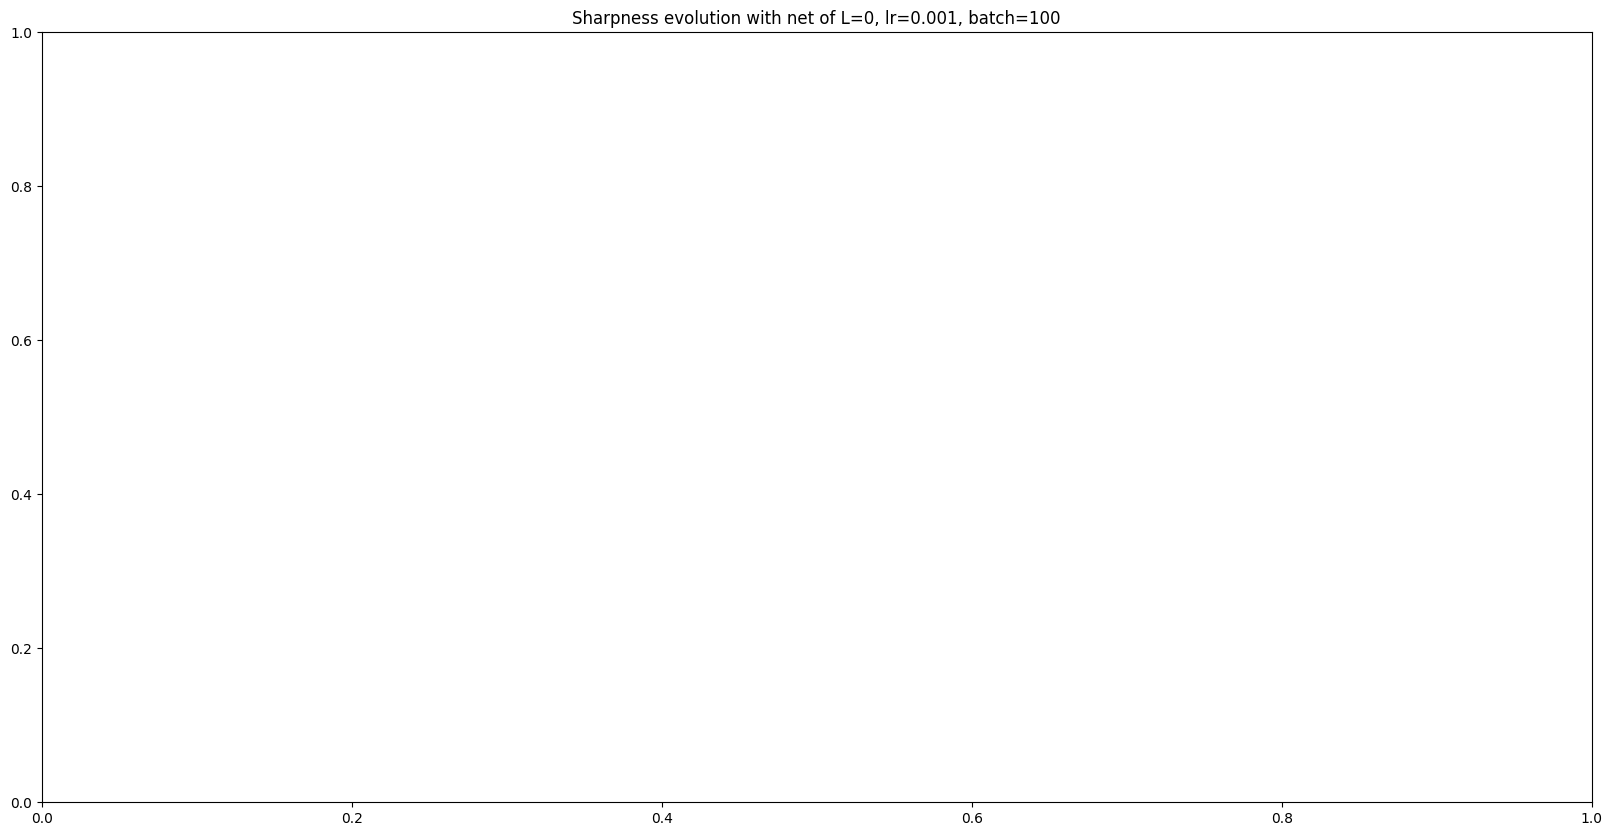

In [4]:
def SHARP():
    T = epochs*len(X)//batch
    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'gray', 'orange', 'purple']
    plt.figure(figsize=(20,10))
    plt.title(f'Sharpness evolution with net of L={L}, lr={2/eos}, batch={batch}')
    N = 128
    for regime,ls in zip(['ntk','mup'],['-',':']):

        lam_rec = []

        with open(f'/Users/alessandrobreccia/Desktop/THESIS/data/lamda{N}_{regime}.txt', 'r') as file:
            lines = file.readlines()

        for line in lines:
            lst = list(map(float, line.strip(',').split()))
            lam_rec.append(lst)
                
        a = np.array(lam_rec).T

        sh1 = a[0:T]
        sh2 = a[T:3*T]
        sh3 = a[3*T:6*T]
        sh4 = a[6*T:10*T]
    
        for i,sh in enumerate([sh1,sh2,sh3,sh4]):
            plt.axvline(i*T, color='r', linestyle='dotted')
            for j,row in enumerate(sh.reshape(T,i+1).T):
                plt.plot(np.arange(i*T,(i+1)*T,1), row, color=colors[j], linestyle=ls)

    plt.ylabel('Sharpness')
    plt.xlabel('Epochs')
    #plt.axhline(eos, color='black', linestyle='dotted')
    plt.grid()
    plt.show()

SHARP()

In [1]:
def ACC():
    T = epochs*len(X)//batch
    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'gray', 'orange', 'purple']
    fig = plt.figure(figsize=(16,8))

    for k,N in enumerate([64,128]):
        for regime,ls in zip(['sp','ntk','mup'],['o','*','+']):

            acc_rec = []

            with open(f'/Users/alessandrobreccia/Desktop/THESIS/data/acc{N}_{regime}.txt', 'r') as file:
                lines = file.readlines()

            for line in lines:
                lst = list(map(float, line.strip(',').split()))
                acc_rec.append(lst)
                    
            a = np.array(acc_rec).T

            accs = [a[:1],a[1:3],a[3:6],a[6:10]]

            for i in range(n_tasks):
                    plt.plot(range(i,n_tasks+1),[a[i] for a in accs[i:]], color=colors[i*k+i], marker=ls, label=f'{regime}_{N}')
            plt.plot(n_tasks,accs[-1][-1], color=colors[-1], marker=ls )
        
    plt.ylabel('Accuracy')
    plt.xlabel('Tasks')
    plt.legend()
    plt.grid()
    plt.show()
ACC()

NameError: name 'epochs' is not defined

In [ ]:
def OVERLAP():
    T = epochs*len(X)//batch
    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'gray', 'orange', 'purple']
    
    plt.figure(figsize=(20,10))
    plt.title(f'Overlap between Hessian of task 1 and gradient at each task')
    N = 128
    for regime,c in zip(['sp','ntk','mup'],[0,1,2]):

        over_rec = []

        with open(f'/Users/alessandrobreccia/Desktop/THESIS/data/overlap{N}_{regime}.txt', 'r') as file:
            lines = file.readlines()

        for line in lines:
            lst = list(map(float, line.strip(',').split()))
            over_rec.append(lst)
                
        a = np.array(over_rec).T

        sh1 = a[0:T]
        sh2 = a[T:2*T]
        sh3 = a[2*T:3*T]
        sh4 = a[3*T:4*T]

        for i,sh in enumerate([sh1,sh2,sh3,sh4]):
            plt.axvline(i*T, color='r', linestyle='dotted')
            for j,row in enumerate(sh.T):
                plt.plot(np.arange(i*T,(i+1)*T,1), row, color=colors[c], label= regime)

    plt.ylabel('Sharpness')
    plt.xlabel('Epochs')
    plt.legend()
    plt.grid()
    plt.show()

OVERLAP()

In [ ]:
def NORM():
    T = epochs*len(X)//batch
    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'gray', 'orange', 'purple']
    
    plt.figure(figsize=(20,10))
    plt.title(f'Weigths norm of the models')
    N = 128
    for regime,c in zip(['sp','ntk','mup'],[0,1,2]):

        norm_rec = []

        with open(f'/Users/alessandrobreccia/Desktop/THESIS/data/norm{N}_{regime}.txt', 'r') as file:
            lines = file.readlines()

        for line in lines:
            lst = list(map(float, line.strip(',').split()))
            norm_rec.append(lst)
                
        a = np.array(norm_rec).T

        sh1 = a[0:T]
        sh2 = a[T:2*T]
        sh3 = a[2*T:3*T]
        sh4 = a[3*T:4*T]

        for i,sh in enumerate([sh1,sh2,sh3,sh4]):
            plt.axvline(i*T, color='r', linestyle='dotted')
            for j,row in enumerate(sh.T):
                plt.plot(np.arange(i*T,(i+1)*T,1), row, color=colors[c], label=regime)

    plt.ylabel('Sharpness')
    plt.xlabel('Epochs')
    plt.grid()
    plt.legend()
    plt.show()

NORM()

In [ ]:
HLT